In [1]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

2024-06-27 15:57:15.924890: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-27 15:57:15.963004: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 15:57:16.702455: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import zipfile
import random
import pathlib
import collections
import cv2
import numpy as np
import tensorflow as tf
from tqdm import tqdm

def list_files_per_class(zip_path):
    """
    List the files in each class of the dataset given the zip path.

    Args:
        zip_path: Path to the local zip file. 

    Return:
        files: List of files in each of the classes.
    """
    files = []
    with zipfile.ZipFile(zip_path, 'r') as zip:
        for zip_info in zip.infolist():
            files.append(zip_info.filename)
    return files

def get_class(fname):
    """
    Retrieve the name of the class given a filename.

    Args:
        fname: Name of the file in the UCF101 dataset.

    Return:
        Class that the file belongs to.
    """
    return fname.split('_')[-3]

def get_files_per_class(files):
    """
    Retrieve the files that belong to each class. 

    Args:
        files: List of files in the dataset.

    Return:
        Dictionary of class names (key) and files (values).
    """
    files_for_class = collections.defaultdict(list)
    for fname in files:
        class_name = get_class(fname)
        files_for_class[class_name].append(fname)
    return files_for_class

def download_from_zip(zip_path, to_dir, file_names):
    """
    Download the contents of the zip file from the zip path.

    Args:
        zip_path: Local zip file path containing data.
        to_dir: Directory to download data to.
        file_names: Names of files to download.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip:
        for fn in tqdm(file_names):
            class_name = get_class(fn)
            zip.extract(fn, str(to_dir / class_name))
            unzipped_file = to_dir / class_name / fn

            fn = pathlib.Path(fn).parts[-1]
            output_file = to_dir / class_name / fn
            unzipped_file.rename(output_file)

def split_class_lists(files_for_class, count):
    """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
        files_for_class: Files belonging to a particular class of data.
        count: Number of files to download.

    Return:
        split_files: Files belonging to the subset of data.
        remainder: Dictionary of the remainder of files that need to be downloaded.
    """
    split_files = []
    remainder = {}
    for cls in files_for_class:
        split_files.extend(files_for_class[cls][:count])
        remainder[cls] = files_for_class[cls][count:]
    return split_files, remainder

def download_ufc_101_subset(zip_path, num_classes, splits, download_dir):
    """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
        zip_path: Local zip file path containing data.
        num_classes: Number of labels.
        splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
                (value is number of files per split).
        download_dir: Directory to download data to.

    Return:
        dir: Posix path of the resulting directories containing the splits of data.
    """
    files = list_files_per_class(zip_path)
    for f in files:
        tokens = f.split('/')
        if len(tokens) <= 2:
            files.remove(f) # Remove that item from the list if it does not have a filename
    
    files_for_class = get_files_per_class(files)

    classes = list(files_for_class.keys())[:num_classes]

    for cls in classes:
        new_files_for_class = files_for_class[cls]
        random.shuffle(new_files_for_class)
        files_for_class[cls] = new_files_for_class
        
    # Only use the number of classes you want in the dictionary
    files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

    dirs = {}
    for split_name, split_count in splits.items():
        print(split_name, ":")
        split_dir = download_dir / split_name
        split_files, files_for_class = split_class_lists(files_for_class, split_count)
        download_from_zip(zip_path, split_dir, split_files)
        dirs[split_name] = split_dir

    return dirs

def format_frames(frame, output_size):
    """
    Pad and resize an image from a video.
    
    Args:
        frame: Image that needs to resized and padded. 
        output_size: Pixel size of the output frame image.

    Return:
        Formatted frame with padding of specified output size.
    """
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

def frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=15):
    """
    Creates frames from each video file present for each category.

    Args:
        video_path: File path to the video.
        n_frames: Number of frames to be created per video file.
        output_size: Pixel size of the output frame image.

    Return:
        A NumPy array of frames in the shape of (n_frames, height, width, channels).
    """
    # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(str(video_path))  

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]

    return result

class FrameGenerator:
    def __init__(self, path, n_frames, training=False):
        """ Returns a set of frames with their associated label. 

        Args:
            path: Video file paths.
            n_frames: Number of frames. 
            training: Boolean to determine if training dataset is being created.
        """
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.avi'))
        classes = [p.parent.name for p in video_paths] 
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()

        pairs = list(zip(video_paths, classes))

        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames) 
            label = self.class_ids_for_name[name] # Encode labels
            yield video_frames, label


In [3]:
# Change the zip file path to your local zip file path
zip_path = pathlib.Path('../data/local_video_action_dataset/CowActionNet.zip')
download_dir = pathlib.Path('./CowActionNet_subset/')
subset_paths = download_ufc_101_subset(zip_path, 
                      num_classes=10, 
                      splits={"train": 5, "val": 5, "test": 5},
                      download_dir=download_dir)

train :


100%|██████████| 21/21 [00:00<00:00, 742.11it/s]


val :


100%|██████████| 10/10 [00:00<00:00, 513.79it/s]


test :


100%|██████████| 2/2 [00:00<00:00, 1180.66it/s]


In [4]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)

# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

2024-06-27 15:57:17.368517: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Training model

In [5]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [6]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)

In [7]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

In [8]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [9]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [10]:
class ResizeVideo(tf.keras.layers.Layer):
    def __init__(self, height, width):
        super().__init__()
        self.height = height
        self.width = width
        self.resizing_layer = layers.Resizing(self.height, self.width)

    def call(self, video):
        # Parse the input shape to ensure dynamic shapes are handled
        batch_size = tf.shape(video)[0]
        time_steps = tf.shape(video)[1]
        height = tf.shape(video)[2]
        width = tf.shape(video)[3]
        channels = tf.shape(video)[4]

        # Reshape video tensor to merge batch and time dimensions
        images = tf.reshape(video, (batch_size * time_steps, height, width, channels))
        
        # Resize images
        resized_images = self.resizing_layer(images)
        
        # Reshape back to the original dimensions with new height and width
        resized_video = tf.reshape(resized_images, (batch_size, time_steps, self.height, self.width, channels))
        
        return resized_video

In [11]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input
x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [12]:
frames, label = next(iter(train_ds))
model.build(frames)

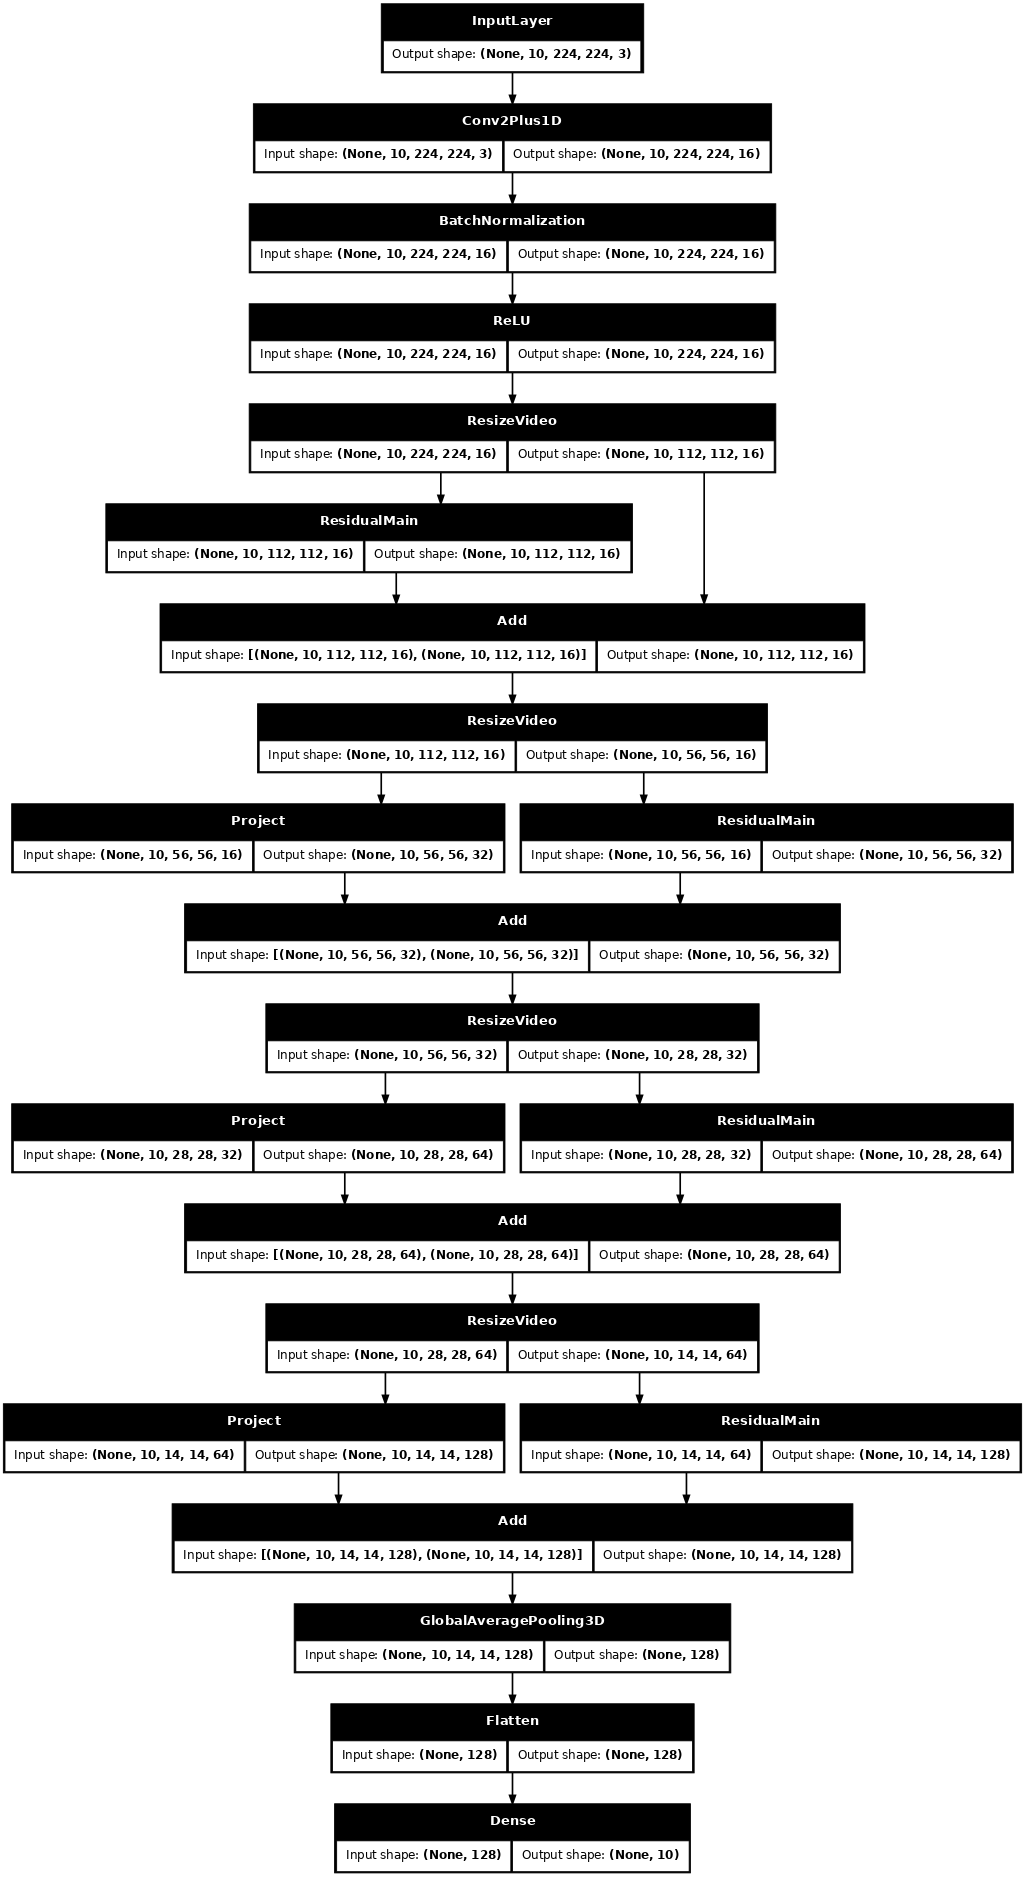

In [13]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [14]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [15]:
history = model.fit(x = train_ds,
                    epochs = 50, 
                    validation_data = val_ds)

Epoch 1/50
      5/Unknown 13s 922ms/step - accuracy: 0.0822 - loss: 3.5707

2024-06-27 15:57:32.863159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/tvlaemynck/anaconda3/envs/myenv/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.0988 - loss: 3.4572 - val_accuracy: 0.0000e+00 - val_loss: 3.7024
Epoch 2/50


2024-06-27 15:57:35.415521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.2667 - loss: 2.1303

2024-06-27 15:57:40.844171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2778 - loss: 2.1161 - val_accuracy: 0.0000e+00 - val_loss: 3.6795
Epoch 3/50


2024-06-27 15:57:42.757771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.3331 - loss: 1.9248

2024-06-27 15:57:48.140663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3382 - loss: 1.8882 - val_accuracy: 0.2273 - val_loss: 3.1736
Epoch 4/50


2024-06-27 15:57:50.077754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.4407 - loss: 1.6287

2024-06-27 15:57:55.524741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4481 - loss: 1.6287 - val_accuracy: 0.2727 - val_loss: 2.8071
Epoch 5/50


2024-06-27 15:57:57.316818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.3771 - loss: 1.6428

2024-06-27 15:58:02.782491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3698 - loss: 1.6464 - val_accuracy: 0.2273 - val_loss: 2.8539
Epoch 6/50


2024-06-27 15:58:04.668756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.2299 - loss: 1.5457

2024-06-27 15:58:10.055394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2270 - loss: 1.5458 - val_accuracy: 0.0000e+00 - val_loss: 3.6716
Epoch 7/50


2024-06-27 15:58:11.949308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.2610 - loss: 1.6137

2024-06-27 15:58:17.409106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2579 - loss: 1.6142 - val_accuracy: 0.0000e+00 - val_loss: 3.6322
Epoch 8/50


2024-06-27 15:58:19.265383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.3663 - loss: 1.4536

2024-06-27 15:58:24.674479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3709 - loss: 1.4493 - val_accuracy: 0.2273 - val_loss: 3.6905
Epoch 9/50


2024-06-27 15:58:26.620642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - accuracy: 0.5303 - loss: 1.4479

2024-06-27 15:58:31.796985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5227 - loss: 1.4614 - val_accuracy: 0.2273 - val_loss: 3.6498
Epoch 10/50


2024-06-27 15:58:33.689510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.4638 - loss: 1.4457

2024-06-27 15:58:38.973884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4623 - loss: 1.4489 - val_accuracy: 0.0000e+00 - val_loss: 3.8930
Epoch 11/50


2024-06-27 15:58:40.857876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.4263 - loss: 1.4120

2024-06-27 15:58:46.155805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4310 - loss: 1.4087 - val_accuracy: 0.0000e+00 - val_loss: 3.6868
Epoch 12/50


2024-06-27 15:58:48.055875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 893ms/step - accuracy: 0.3604 - loss: 1.5415

2024-06-27 15:58:53.286660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3559 - loss: 1.5463 - val_accuracy: 0.1818 - val_loss: 3.3185
Epoch 13/50


2024-06-27 15:58:55.185937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.3477 - loss: 1.3739

2024-06-27 15:59:00.580168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3504 - loss: 1.3850 - val_accuracy: 0.2727 - val_loss: 2.7614
Epoch 14/50


2024-06-27 15:59:02.479463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.4034 - loss: 1.5043

2024-06-27 15:59:07.949804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4119 - loss: 1.4851 - val_accuracy: 0.0455 - val_loss: 3.1208
Epoch 15/50


2024-06-27 15:59:09.824770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.2958 - loss: 1.5083

2024-06-27 15:59:15.103531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3021 - loss: 1.4997 - val_accuracy: 0.0000e+00 - val_loss: 3.4219
Epoch 16/50


2024-06-27 15:59:17.039606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - accuracy: 0.3955 - loss: 1.3939

2024-06-27 15:59:22.618348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3952 - loss: 1.4053 - val_accuracy: 0.0455 - val_loss: 3.2623
Epoch 17/50


2024-06-27 15:59:24.527814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.4390 - loss: 1.3064

2024-06-27 15:59:29.834708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4366 - loss: 1.3094 - val_accuracy: 0.1818 - val_loss: 3.2315
Epoch 18/50


2024-06-27 15:59:31.635434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.3619 - loss: 1.4166

2024-06-27 15:59:36.714953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3723 - loss: 1.4020 - val_accuracy: 0.0909 - val_loss: 3.3831
Epoch 19/50


2024-06-27 15:59:38.553232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.4388 - loss: 1.2559

2024-06-27 15:59:44.150417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4414 - loss: 1.2650 - val_accuracy: 0.0909 - val_loss: 3.3386
Epoch 20/50


2024-06-27 15:59:46.181129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.4759 - loss: 1.3556

2024-06-27 15:59:51.665561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4825 - loss: 1.3467 - val_accuracy: 0.0455 - val_loss: 3.0637
Epoch 21/50


2024-06-27 15:59:53.581433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.4161 - loss: 1.2444

2024-06-27 15:59:59.048785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4175 - loss: 1.2524 - val_accuracy: 0.0909 - val_loss: 3.1741
Epoch 22/50


2024-06-27 16:00:00.956156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.3994 - loss: 1.3194

2024-06-27 16:00:06.442896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4036 - loss: 1.3132 - val_accuracy: 0.0909 - val_loss: 3.1366
Epoch 23/50


2024-06-27 16:00:08.375135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 913ms/step - accuracy: 0.5597 - loss: 1.1183

2024-06-27 16:00:13.810390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5421 - loss: 1.1554 - val_accuracy: 0.0909 - val_loss: 2.9699
Epoch 24/50


2024-06-27 16:00:15.720666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.4619 - loss: 1.2336

2024-06-27 16:00:21.047048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4557 - loss: 1.2488 - val_accuracy: 0.0000e+00 - val_loss: 2.8665
Epoch 25/50


2024-06-27 16:00:22.837348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.4473 - loss: 1.3424

2024-06-27 16:00:28.309977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4435 - loss: 1.3429 - val_accuracy: 0.2273 - val_loss: 2.6589
Epoch 26/50


2024-06-27 16:00:29.982488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.4369 - loss: 1.3233

2024-06-27 16:00:35.310472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4348 - loss: 1.3180 - val_accuracy: 0.2727 - val_loss: 2.5693
Epoch 27/50


2024-06-27 16:00:37.119172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 917ms/step - accuracy: 0.4222 - loss: 1.3368

2024-06-27 16:00:42.635821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4276 - loss: 1.3365 - val_accuracy: 0.1818 - val_loss: 2.9718
Epoch 28/50


2024-06-27 16:00:44.458361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.4409 - loss: 1.3758

2024-06-27 16:00:49.906850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4432 - loss: 1.3607 - val_accuracy: 0.0000e+00 - val_loss: 3.4034
Epoch 29/50


2024-06-27 16:00:51.845642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 917ms/step - accuracy: 0.3604 - loss: 1.4024

2024-06-27 16:00:57.229548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3559 - loss: 1.4180 - val_accuracy: 0.0000e+00 - val_loss: 3.0943
Epoch 30/50


2024-06-27 16:00:59.083033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.3288 - loss: 1.3639

2024-06-27 16:01:04.358914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3396 - loss: 1.3506 - val_accuracy: 0.2727 - val_loss: 2.5442
Epoch 31/50


2024-06-27 16:01:06.209998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.4494 - loss: 1.2168

2024-06-27 16:01:11.643000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4452 - loss: 1.2380 - val_accuracy: 0.2727 - val_loss: 2.5595
Epoch 32/50


2024-06-27 16:01:13.456537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 0.4347 - loss: 1.3483

2024-06-27 16:01:18.704572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4380 - loss: 1.3463 - val_accuracy: 0.0909 - val_loss: 3.0244
Epoch 33/50


2024-06-27 16:01:20.520955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.4996 - loss: 1.2188

2024-06-27 16:01:25.858189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4820 - loss: 1.2482 - val_accuracy: 0.0000e+00 - val_loss: 3.5260
Epoch 34/50


2024-06-27 16:01:27.681878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.3619 - loss: 1.3535

2024-06-27 16:01:33.006906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3723 - loss: 1.3423 - val_accuracy: 0.0909 - val_loss: 3.2046
Epoch 35/50


2024-06-27 16:01:34.941038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.3621 - loss: 1.3080

2024-06-27 16:01:40.345678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3674 - loss: 1.2964 - val_accuracy: 0.2273 - val_loss: 2.9493
Epoch 36/50


2024-06-27 16:01:42.221194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.4780 - loss: 1.2374

2024-06-27 16:01:47.429035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4842 - loss: 1.2262 - val_accuracy: 0.2273 - val_loss: 2.7988
Epoch 37/50


2024-06-27 16:01:49.287200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.5055 - loss: 1.1375

2024-06-27 16:01:54.663525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4970 - loss: 1.1545 - val_accuracy: 0.2727 - val_loss: 2.6198
Epoch 38/50


2024-06-27 16:01:56.594306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.5011 - loss: 1.1616

2024-06-27 16:02:01.872235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4984 - loss: 1.1666 - val_accuracy: 0.1364 - val_loss: 2.8641
Epoch 39/50


2024-06-27 16:02:03.844329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - accuracy: 0.4223 - loss: 1.2147

2024-06-27 16:02:09.189107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4227 - loss: 1.2233 - val_accuracy: 0.0455 - val_loss: 2.9753
Epoch 40/50


2024-06-27 16:02:11.032561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.5884 - loss: 1.2021

2024-06-27 16:02:16.514314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5762 - loss: 1.2241 - val_accuracy: 0.0909 - val_loss: 3.1132
Epoch 41/50


2024-06-27 16:02:18.377776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.4136 - loss: 1.2343

2024-06-27 16:02:23.782242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4255 - loss: 1.2277 - val_accuracy: 0.2273 - val_loss: 2.6853
Epoch 42/50


2024-06-27 16:02:25.675364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.3553 - loss: 1.3648

2024-06-27 16:02:30.962720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3769 - loss: 1.3437 - val_accuracy: 0.3182 - val_loss: 2.1954
Epoch 43/50


2024-06-27 16:02:32.791357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.4657 - loss: 1.2478

2024-06-27 16:02:38.078949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4689 - loss: 1.2529 - val_accuracy: 0.2727 - val_loss: 2.3293
Epoch 44/50


2024-06-27 16:02:39.964723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 905ms/step - accuracy: 0.5472 - loss: 1.2159

2024-06-27 16:02:45.433414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5317 - loss: 1.2327 - val_accuracy: 0.2273 - val_loss: 2.3713
Epoch 45/50


2024-06-27 16:02:47.336061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.5402 - loss: 1.2051

2024-06-27 16:02:52.787079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5461 - loss: 1.1927 - val_accuracy: 0.0909 - val_loss: 2.5727
Epoch 46/50


2024-06-27 16:02:54.714601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.5362 - loss: 1.1300

2024-06-27 16:03:00.354890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5377 - loss: 1.1405 - val_accuracy: 0.0455 - val_loss: 2.7521
Epoch 47/50


2024-06-27 16:03:02.139319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - accuracy: 0.5864 - loss: 1.0183

2024-06-27 16:03:07.701305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5745 - loss: 1.0472 - val_accuracy: 0.0909 - val_loss: 2.9049
Epoch 48/50


2024-06-27 16:03:09.605354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.5761 - loss: 1.1271

2024-06-27 16:03:15.098482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5609 - loss: 1.1508 - val_accuracy: 0.0909 - val_loss: 2.8486
Epoch 49/50


2024-06-27 16:03:17.037551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.4390 - loss: 1.1850

2024-06-27 16:03:22.336842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4366 - loss: 1.1871 - val_accuracy: 0.2727 - val_loss: 2.5507
Epoch 50/50


2024-06-27 16:03:24.098650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.5049 - loss: 1.1989

2024-06-27 16:03:29.558806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5117 - loss: 1.1892 - val_accuracy: 0.2273 - val_loss: 2.6312


2024-06-27 16:03:31.493887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


## Visualize

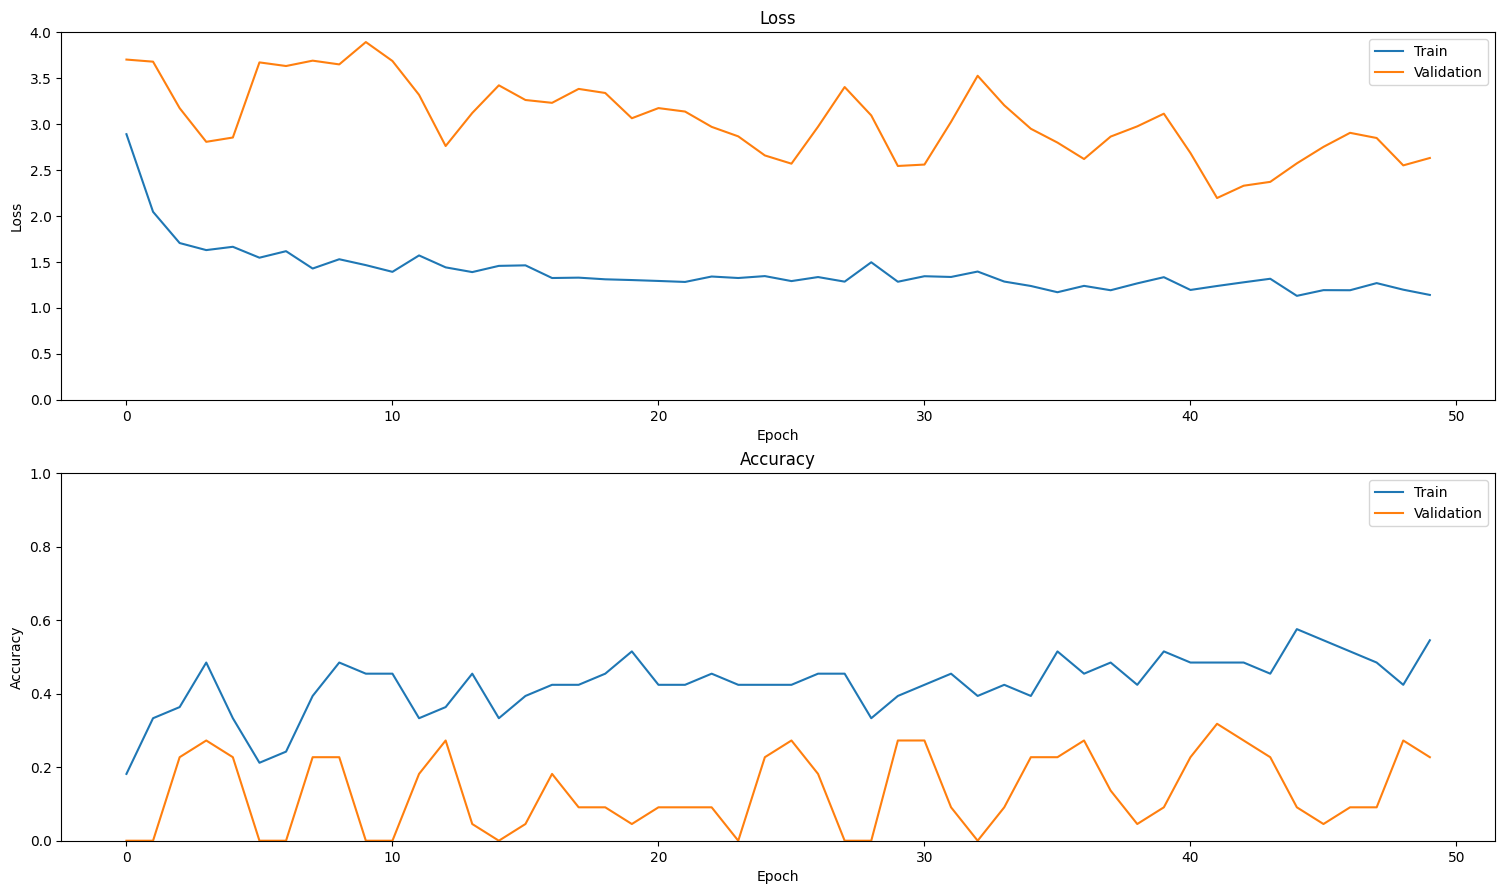

In [16]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

## Evaluate

In [17]:
model.evaluate(test_ds, return_dict=True)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.3068 - loss: 2.5334


2024-06-27 16:05:17.713338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


{'accuracy': 0.27272728085517883, 'loss': 2.5648062229156494}

In [18]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [20]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

2024-06-27 16:06:49.506296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 555ms/step


2024-06-27 16:06:53.511007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


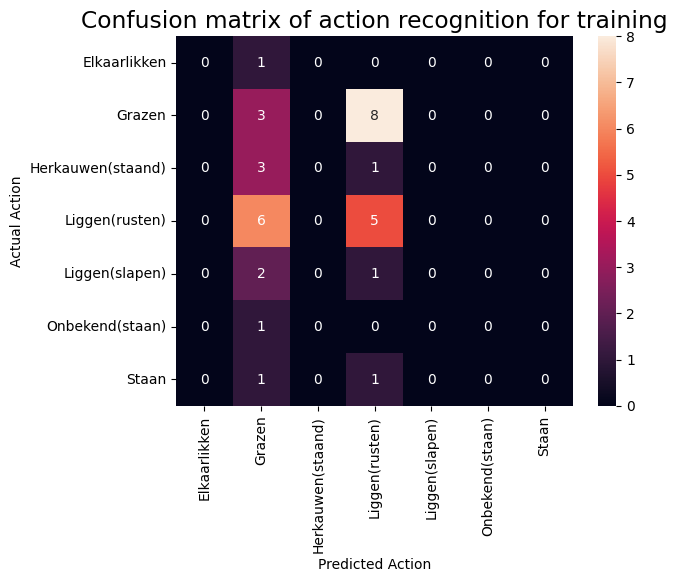

In [21]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

2024-06-27 16:06:54.768190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


2024-06-27 16:06:55.890002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/tvlaemynck/anaconda3/envs/myenv/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (7).

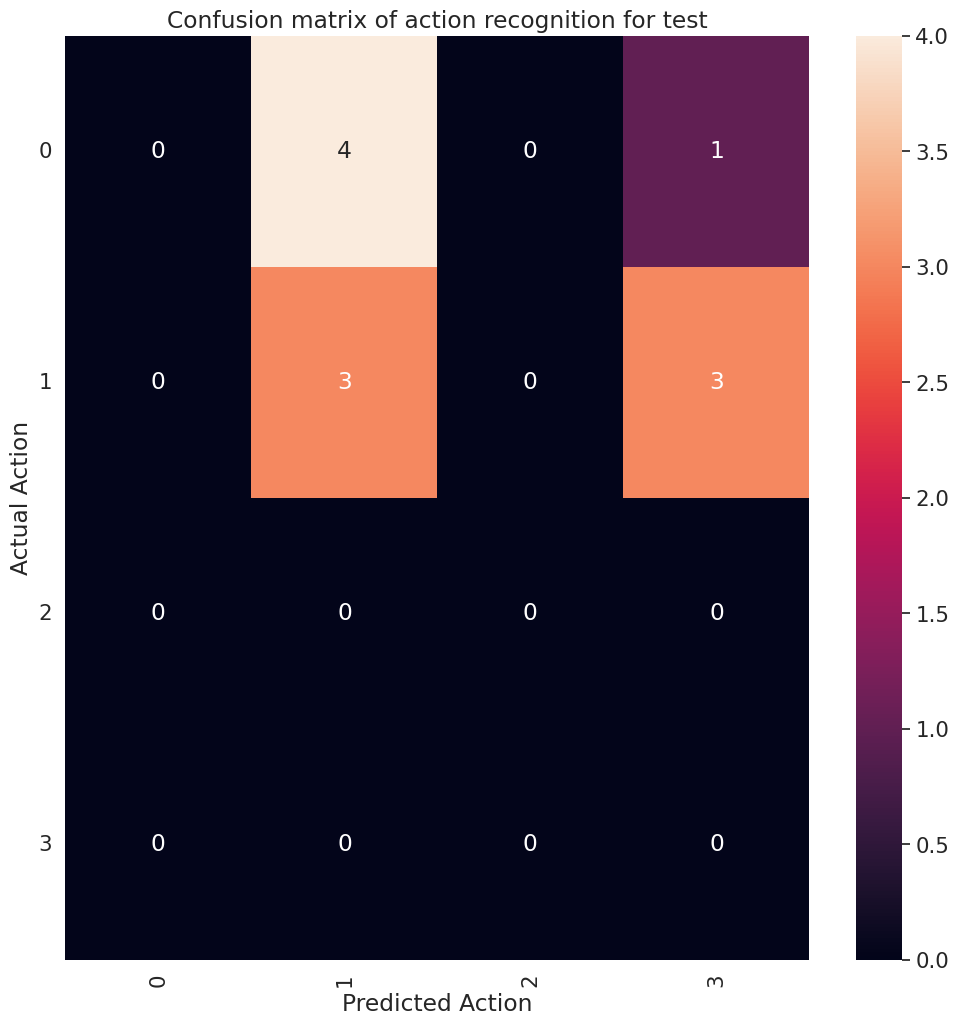

In [22]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [23]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [24]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

/tmp/ipykernel_58585/791028922.py:25: RuntimeWarning: invalid value encountered in scalar divide
  precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision
/tmp/ipykernel_58585/791028922.py:27: RuntimeWarning: invalid value encountered in scalar divide
  recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
2024-06-27 16:07:34.505853: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 4 of dimension 1 out of bounds.
2024-06-27 16:07:34.505912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: slice index 4 of dimension 1 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 4 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/

In [ ]:
precision

In [ ]:
recall